In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Thu_Nov_18_09:45:30_PST_2021
Cuda compilation tools, release 11.5, V11.5.119
Build cuda_11.5.r11.5/compiler.30672275_0


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, sys # filesystem operations
import matplotlib.pyplot as plt
import cv2
import random
import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from argparse import Namespace
import tensorflow.keras.datasets
import matplotlib.pyplot

2024-03-11 17:02:53.647332: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-11 17:02:53.697211: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-11 17:02:54.575917: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# Preparing MNIST Dataset
(x_train_orig, y_train), (x_test_orig, y_test) = tensorflow.keras.datasets.mnist.load_data()
x_train_orig = x_train_orig.astype("float32") / 255.0
x_test_orig = x_test_orig.astype("float32") / 255.0
x_train = np.reshape(x_train_orig, newshape=(x_train_orig.shape[0], np.prod(x_train_orig.shape[1:])))
x_test = np.reshape(x_test_orig, newshape=(x_test_orig.shape[0], np.prod(x_test_orig.shape[1:])))
print(set(y_train))
class DS():
    def __init__(self, x_data, y_data):
        self.data=x_data
        self.labels=y_data
        self.categories=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        #class_id = torch.as_tensor(self.categories.index(self.labels[idx]), dtype=torch.int64)
        img=self.data[idx]
        return torch.tensor(img), torch.tensor(img)
train_data=DS(x_train, x_train)
test_data=DS(x_test, x_test)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [5]:
# Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.dense_layer1 = nn.Linear(in_features=784, out_features=300)
        self.dense_layer2 = nn.Linear(in_features=300, out_features=4)

    def forward(self, x):
        x = F.leaky_relu(self.dense_layer1(x))
        x = F.leaky_relu(self.dense_layer2(x))
        return x

In [6]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.dense_layer1 = nn.Linear(in_features=4, out_features=300)
        self.dense_layer2 = nn.Linear(in_features=300, out_features=784)

    def forward(self, x):
        x = F.leaky_relu(self.dense_layer1(x))
        x = F.leaky_relu(self.dense_layer2(x))
        return x

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
myEncoder=Encoder()
myDecoder=Decoder()

In [11]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)
myModel = Autoencoder(myEncoder, myDecoder)
myModel = myModel.to(device)
train_dl=torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_dl=torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

cuda:0


In [9]:
def inference (model, val_dl):
    all_preds=[]
    all_labels=[]
    correct_prediction = 0
    total_prediction = 0

    # Disable gradient updates
    with torch.no_grad():
        for data in val_dl:
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Get predictions
            outputs = model(inputs)

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
            
            all_preds.append(prediction.to(torch.device("cpu")))
            all_labels.append(labels.to(torch.device("cpu")))
    acc = correct_prediction/total_prediction
    print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')
    return all_preds, all_labels, acc

In [10]:
testacclist=[]
trainingacclist=[]

In [20]:
def training(model, train_dl, num_epochs, iteration):
    # Loss Function, Optimizer and Scheduler  
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)#01)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs
                                                )

    # Repeat for each epoch
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0

        # Repeat for each batch in the training set
        for i, data in enumerate(train_dl):
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)
            #print(labels.is_cuda)
            #print(np.shape(inputs))
            # Normalize the inputs
            #inputs_m, inputs_s = inputs.mean(), inputs.std()
            #inputs = (inputs - inputs_m) / inputs_s
            #print(inputs.is_cuda)
            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            #print(outputs.is_cuda)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Keep stats for Loss and Accuracy
            running_loss += loss.item()
        print(running_loss)
        print(epoch)
for i in range(1):
    num_epochs=40
    iteration=i
    training(myModel, train_dl, num_epochs, iteration)
    #trainingacclist.append(trainacc)
    
    #temp1, temp2, testacc=inference(myModel, test_dl)
    #testacclist.append(testacc)
#x_axis = list(range(1, len(testacclist) + 1))
#plt.plot(x_axis, trainingacclist, x_axis, testacclist)

28.37727333046496
0
28.449555350467563
1
28.599484337493777
2
28.789523208513856
3
28.963422434404492
4
29.071595123037696
5
29.119824070483446
6
29.120114982128143
7
29.04029551334679
8
28.946661619469523
9
28.801227239891887
10
28.629961039870977
11
28.454194024205208
12
28.27207527682185
13
28.081301415339112
14
27.907068265601993
15
27.752271046862006
16
27.58260765299201
17
27.41126362234354
18
27.267693359404802
19
27.095579659566283
20
26.951081104576588
21
26.784507635980844
22
26.61750976368785
23
26.471731536090374
24
26.32269816286862
25
26.18790509365499
26
26.04149341210723
27
25.905742160975933
28
25.78254819661379
29
25.67033783905208
30
25.556417755782604
31
25.460753194987774
32
25.372045824304223
33
25.298607235774398
34
25.236292270943522
35
25.188717301934958
36
25.146643608808517
37
25.11983721703291
38
25.10646310262382
39


tensor([4.4763, 6.7185, 8.3424, 4.3088], device='cuda:0',
       grad_fn=<LeakyReluBackward0>)


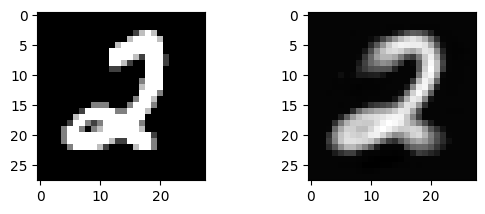

In [42]:
for i, data in enumerate(test_dl):
    # Get the input features and target labels, and put them on the GPU
    inputs, labels = data[0].to(device), data[1].to(device)
    break
#print(inputs.shape)
orig=inputs[0].reshape(28,28)
output=myEncoder(inputs[0])
print(output)
output=myDecoder(output)

output=output.detach().cpu().numpy()
output=output.reshape(28,28)
matplotlib.pyplot.subplot(2, 2, 1)
matplotlib.pyplot.imshow(orig.detach().cpu(), cmap="gray")
matplotlib.pyplot.subplot(2, 2, 2)
matplotlib.pyplot.imshow(output, cmap="gray")